Regular Laplacian & Random/Null Laplacian Comparison
--

Here we compare the complex Laplacian performance:
 1) The regular Laplacian does not have the wave number $k$ parameter, and does not have a complex component. 
 2) Random Laplacian uses values sampled from a distribution of pairwise Brain ROI distances, the sampled connectome is symmetrized, with 0 diagonal, and have similar sparsity as the actual HCP template connectome.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.stats import spearmanr, pearsonr
from scipy.linalg import lstsq
from sklearn.preprocessing import minmax_scale

# spectrome imports:
from spectrome.brain import Brain
from spectrome.utils import functions, path, generate
from spectrome.forward import eigenmode, laplacian

In [2]:
## Normal house-keeping:
data_dir = "../data"

# Load Pablo's Yeo 2017 canonical network maps
#fc_dk = np.load("../data/com_dk.npy", allow_pickle=True).item()
fc_dk_normalized = pd.read_csv("../data/DK_dictionary_normalized.csv").set_index(
    "Unnamed: 0"
)

# define list of canonical network names and re-order the dictionary using these names:
fc_names = [
    "Limbic",
    "Default",
    "Visual",
    "Fronto \n parietal",
    "Somato \n motor",
    "Dorsal \n Attention",
    "Ventral \n Attention",
]

fc_dk_normalized = fc_dk_normalized.reindex(
    [
        "Limbic",
        "Default",
        "Visual",
        "Frontoparietal",
        "Somatomotor",
        "Dorsal_Attention",
        "Ventral_Attention",
    ]
).fillna(0)

### Load optimal results from complex Laplacian optimization:

In [3]:
opt_param = np.zeros([len(fc_names), 2])

## Load the optimized parameters first
h5_path = os.path.join(data_dir, "default.h5")
bh_default = path.read_hdf5(h5_path)
opt_param[1, :] = bh_default["x"]
# print('Default network parameters:' + str(np.round(bh_default['x'],2)))

h5_path = os.path.join(data_dir, "dorsal.h5")
bh_dorsal = path.read_hdf5(h5_path)
opt_param[5, :] = bh_dorsal["x"]
# print('Doral Attention network parameters:' + str(np.round(bh_dorsal['x'],2)))

h5_path = os.path.join(data_dir, "fronto.h5")
bh_front = path.read_hdf5(h5_path)
opt_param[3, :] = bh_front["x"]
# print('Frontoparietal network parameters:' + str(np.round(bh_front['x'],2)))

h5_path = os.path.join(data_dir, "limbic.h5")
bh_limbic = path.read_hdf5(h5_path)
opt_param[0, :] = bh_limbic["x"]
# print('Limbic network parameters:' + str(np.round(bh_limbic['x'],2)))

h5_path = os.path.join(data_dir, "motor.h5")
bh_motor = path.read_hdf5(h5_path)
opt_param[4, :] = bh_motor["x"]
# print('Somatomotor network parameters:' + str(np.round(bh_motor['x'],2)))

h5_path = os.path.join(data_dir, "ventral.h5")
bh_ventral = path.read_hdf5(h5_path)
opt_param[6, :] = bh_ventral["x"]
# print('Ventral Attention network parameters:' + str(np.round(bh_ventral['x'],2)))

h5_path = os.path.join(data_dir, "visual.h5")
bh_visual = path.read_hdf5(h5_path)
opt_param[2, :] = bh_visual["x"]
# print('Visual network parameters:' + str(np.round(bh_visual['x'],2)))

# pile these parameters:
parameters = pd.DataFrame(
    data=opt_param, index=fc_dk_normalized.index, columns=["alpha", "wave_number"]
)
print(parameters)

                      alpha  wave_number
Unnamed: 0                              
Limbic             3.925240    74.848400
Default            2.969416    30.411254
Visual             3.880239   249.444195
Frontoparietal     2.930907    42.269656
Somatomotor        1.000000   100.000000
Dorsal_Attention   2.595946    78.541201
Ventral_Attention  3.320573    60.764753


Define a function for computing residuals & spatial correlation:

In [4]:
def compute_linreg_scores(fnetworks, a, kk, fc_name, num_em, corr_type = "spearman", lap_type="complex"):
    # build the Brain object first:
    brain = Brain.Brain()
    brain.add_connectome(data_dir)
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()

    # decompose laplacian eigenmodes and pre-allocate array for correlation calculations
    if lap_type is "complex":
        #print('computing for complex laplacian')
        brain.decompose_complex_laplacian(alpha=a, k=kk, vis=False)
    elif lap_type is "regular":
        #print('computing for regular laplacian')
        brain.decompose_regular_laplacian(alpha=a)
    elif lap_type is "random":
        #print('computing for random laplacian')
        brain.reducedConnectome = generate.exp_neg_dist_Cij(brain.distance_matrix)
        brain.decompose_complex_laplacian(alpha=a, k=kk, vis=False)

    # compute spatial correlation:
    corrs = np.squeeze(np.zeros([brain.norm_eigenmodes.shape[1], 1]))
    canon_network = np.nan_to_num(fnetworks.loc[fc_name].values)
    for e in np.arange(0, len(corrs)):
        if corr_type is "spearman":
            prcorr = spearmanr(np.squeeze(canon_network), brain.norm_eigenmodes[:, e])[0]
        elif corr_type is "pearson":
            prcorr = pearsonr(np.squeeze(canon_network), brain.norm_eigenmodes[:, e])[0]
        corrs[e] = prcorr

    # sorting and pre-allocate for cumulative results
    ntw_opt_corr = np.round(corrs, 3)
    ordered_corr = np.argsort(-ntw_opt_corr)  # sort by correlation performance
    cumulative_regr = np.zeros([num_em, 1])
    cumulative_corr = np.zeros([num_em, 1])

    # for each eigenmode, compute linear least square weights and combine:
    for k in np.arange(0, num_em):
        selected_eigs = brain.norm_eigenmodes[:, ordered_corr[0 : k + 1]]
        coef, _, _, _ = lstsq(selected_eigs, canon_network, lapack_driver="gelsy")

        comb_corr = np.squeeze(np.matmul(selected_eigs, np.asarray(coef)))
        dp = np.dot(selected_eigs, np.asarray(coef)) ** 2
        residual = np.sum(canon_network - dp)

        #cumulative_corr[k] = pearsonr(np.squeeze(canon_network), comb_corr)[0]
        if corr_type is "spearman":
            cumulative_corr[k] = spearmanr(np.squeeze(canon_network), comb_corr)[0]
        if corr_type is "pearson":
            cumulative_corr[k] = pearsonr(np.squeeze(canon_network), comb_corr)[0]
        cumulative_regr[k] = residual
    return np.squeeze(cumulative_regr), np.squeeze(cumulative_corr)

Use the above function for all functional networks: 

In [5]:
K = 30  # number of eigenmodes
regr_comp = np.zeros([K, 7])
corr_comp = np.zeros([K, 7])

for i in np.arange(0, len(fc_names)):
    regr_comp[:, i], corr_comp[:, i] = compute_linreg_scores(
        fc_dk_normalized,
        a=parameters.iloc[i, 0],
        kk=parameters.iloc[i, 1],
        fc_name=fc_dk_normalized.index[i],
        num_em=K,
    )

In [6]:
## Do the same for real laplacian:
regr_reg = np.zeros([K, 7])
corr_reg = np.zeros([K, 7])

for i in np.arange(0, len(fc_names)):
    regr_reg[:, i], corr_reg[:, i] = compute_linreg_scores(
        fc_dk_normalized,
        a=parameters.iloc[i, 0],
        kk=parameters.iloc[i, 1],
        fc_name=fc_dk_normalized.index[i],
        num_em=K,
        lap_type="regular",
    )

In [ ]:
from tqdm import tqdm_notebook

## Random connectome based on distance:
rng_runs = 1000
np.random.seed(24)

dft_rdnr = np.zeros([K, rng_runs])
dft_rdnc = np.zeros([K, rng_runs])

limbic_rdnr = np.zeros([K, rng_runs])
limbic_rdnc = np.zeros([K, rng_runs])

visual_rdnr = np.zeros([K, rng_runs])
visual_rdnc = np.zeros([K, rng_runs])

front_rdnr = np.zeros([K, rng_runs])
front_rdnc = np.zeros([K, rng_runs])

motor_rdnr = np.zeros([K, rng_runs])
motor_rdnc = np.zeros([K, rng_runs])

ventral_rdnr = np.zeros([K, rng_runs])
ventral_rdnc = np.zeros([K, rng_runs])

dorsal_rdnr = np.zeros([K, rng_runs])
dorsal_rdnc = np.zeros([K, rng_runs])

for n in tqdm_notebook(np.arange(0, rng_runs), desc = 'random connectomes'):
    limbic_rdnr[:, n], limbic_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_limbic["x"][0],
        kk=bh_limbic["x"][1],
        fc_name="Limbic",
        num_em=K,
        lap_type="random",
    )

    dft_rdnr[:, n], dft_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_default["x"][0],
        kk=bh_default["x"][1],
        fc_name="Default",
        num_em=K,
        lap_type="random",
    )

    visual_rdnr[:, n], visual_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_visual["x"][0],
        kk=bh_visual["x"][1],
        fc_name="Visual",
        num_em=K,
        lap_type="random",
    )

    front_rdnr[:, n], front_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_front["x"][0],
        kk=bh_front["x"][1],
        fc_name="Frontoparietal",
        num_em=K,
        lap_type="random",
    )

    motor_rdnr[:, n], motor_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_motor["x"][0],
        kk=bh_motor["x"][1],
        fc_name="Somatomotor",
        num_em=K,
        lap_type="random",
    )

    dorsal_rdnr[:, n], dorsal_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_dorsal["x"][0],
        kk=bh_dorsal["x"][1],
        fc_name="Dorsal_Attention",
        num_em=K,
        lap_type="random",
    )

    ventral_rdnr[:, n], ventral_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_ventral["x"][0],
        kk=bh_ventral["x"][1],
        fc_name="Ventral_Attention",
        num_em=K,
        lap_type="random",
    )

In [ ]:
#save the intermediate results:
np.savez('../data/distance_connectome_30eigs_rr.npz', limbic_regr = limbic_rdnr, limbic_corr = limbic_rdnc,
        default_regr = dft_rdnr, default_corr = dft_rdnc,
        visual_regr = visual_rdnr, visual_corr = visual_rdnc,
        front_regr = front_rdnr, front_corr = front_rdnc,
        motor_regr = motor_rdnr, motor_corr = motor_rdnc,
        dorsal_regr = dorsal_rdnr, dorsal_corr = dorsal_rdnc,
        ventral_regr = ventral_rdnr, ventral_corr = ventral_rdnc)

In [7]:
# load the npz file:
cdist = np.load('../data/distance_connectome_30eigs_rr.npz')

### Compute 95% confidence interval for null distribution error bars:

In [8]:
import scipy.stats

def get_zscore(in_data):
    sample_size = in_data.shape[1]
    num_eig = in_data.shape[0]
    confint = np.zeros([2,num_eig])
    r2z_values = np.zeros([num_eig, sample_size])
    
    for eig in np.arange(0,num_eig):
        z = np.arctanh(in_data[eig,:])
        SDz = np.std(z)
        cfstat = scipy.stats.norm.ppf(0.95)*SDz
        confint[0,eig] = np.mean(in_data[eig,:]) - np.tanh(np.mean(in_data[eig,:])-cfstat) #lower
        confint[1,eig] = np.tanh(np.mean(in_data[eig,:])+cfstat) - np.mean(in_data[eig,:]) #upper
        r2z_values[eig,:] = z
        #confint[0,eig] = np.tanh(np.mean(in_data[eig,:])-cfstat)-np.mean(in_data[eig,:]) #lower
        #confint[1,eig] = np.tanh(np.mean(in_data[eig,:])+cfstat)-np.mean(in_data[eig,:]) #upper
    upper_cfint = confint[1,:]
    lower_cfint = confint[0,:]
    return upper_cfint, lower_cfint, r2z_values

def get_errorbar(in_data):
    n = len(in_data)
    xbar = np.mean(in_data)
    s = np.std(in_data)
    z = 1.96
    
    confint = np.zeros([2, n])
    confint[0,:] = xbar - (xbar - (z * (s/np.sqrt(n))))
    confint[1,:] = (xbar + (z * (s/np.sqrt(n)))) - xbar
    return confint

plot the performances for the 3 laplacians:

1 limbic_corr
3 default_corr
5 visual_corr
7 front_corr
9 motor_corr
11 dorsal_corr
13 ventral_corr


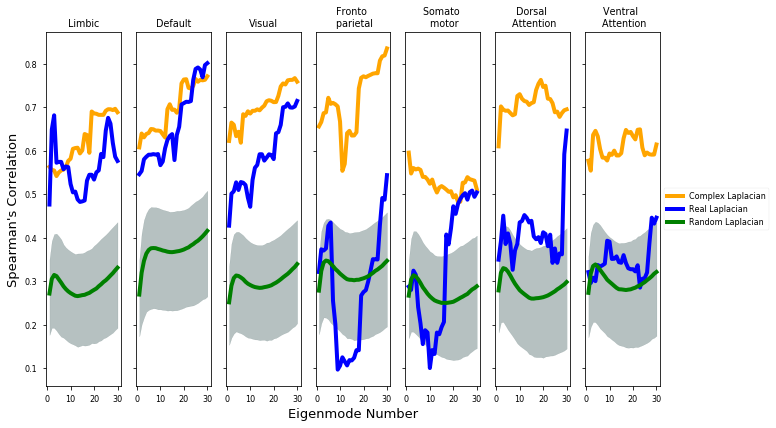

In [9]:
import string
LW = 4
cf = 0.95
upper_cf = np.zeros([len(fc_names), K])
lower_cf = np.zeros(upper_cf.shape)
x = np.arange(1,K+1) # 1-K integers for x axis for number of eigenmodes
rdn_spearman_mean = np.zeros([len(fc_names), K])

c = 0
for i, keys in enumerate(cdist.keys()):
    if (i&1 == 1):
        print(i, keys)
        rdn_spearman_mean[c,:] = np.mean(cdist[keys], axis = 1)
        upper_cf[c,:], lower_cf[c,:], _ = get_zscore(cdist[keys])
        c += 1

with plt.style.context('seaborn-paper'):
    fit_fig, fit_ax = plt.subplots(1,7, figsize = (11,6.5), sharey = True)
    for i, ax in enumerate(fit_ax):
        ax.plot(x, corr_comp[0:K,i], color = 'orange', linewidth = LW)
        ax.plot(x, corr_reg[0:K,i], color = 'blue', linewidth = LW)
        ax.plot(x, rdn_spearman_mean[i,:], color = 'green', linewidth = LW)
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        ax.title.set_text(fc_names[i])
        ax.fill_between(x, rdn_spearman_mean[i,:] - lower_cf[i,:], rdn_spearman_mean[i,:] + upper_cf[i,:], 
                   color = 'darkslategray', alpha = 0.35)
        
    plt.legend(['Complex Laplacian', 'Real Laplacian', 'Random Laplacian'],
              loc = 'center left', bbox_to_anchor = (1, 0.5))
    
    fit_fig.add_subplot(1,1,1, frameon = False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel(string.capwords("Spearman's Correlation"), fontsize = 13)
    plt.xlabel('Eigenmode Number', fontsize = 13)

    plt.savefig('../figures/fig6/spearman.png', dpi = 300, bbox_inches = 'tight')

#### Repeat the same procedure but with Pearson correlation:

In [8]:
# load Pearson R optimized parameters:
opt_param = np.zeros([len(fc_names), 3])

## Load the optimized parameters first
h5_path = os.path.join(data_dir, "default_pearson.h5")
bh_default = path.read_hdf5(h5_path)
opt_param[1, :] = bh_default["x"]
# print('Default network parameters:' + str(np.round(bh_default['x'],2)))

h5_path = os.path.join(data_dir, "dorsal_pearson.h5")
bh_dorsal = path.read_hdf5(h5_path)
opt_param[5, :] = bh_dorsal["x"]
# print('Doral Attention network parameters:' + str(np.round(bh_dorsal['x'],2)))

h5_path = os.path.join(data_dir, "fronto_pearson.h5")
bh_front = path.read_hdf5(h5_path)
opt_param[3, :] = bh_front["x"]
# print('Frontoparietal network parameters:' + str(np.round(bh_front['x'],2)))

h5_path = os.path.join(data_dir, "limbic_pearson.h5")
bh_limbic = path.read_hdf5(h5_path)
opt_param[0, :] = bh_limbic["x"]
# print('Limbic network parameters:' + str(np.round(bh_limbic['x'],2)))

h5_path = os.path.join(data_dir, "motor_pearson.h5")
bh_motor = path.read_hdf5(h5_path)
opt_param[4, :] = bh_motor["x"]
# print('Somatomotor network parameters:' + str(np.round(bh_motor['x'],2)))

h5_path = os.path.join(data_dir, "ventral_pearson.h5")
bh_ventral = path.read_hdf5(h5_path)
opt_param[6, :] = bh_ventral["x"]
# print('Ventral Attention network parameters:' + str(np.round(bh_ventral['x'],2)))

h5_path = os.path.join(data_dir, "visual_pearson.h5")
bh_visual = path.read_hdf5(h5_path)
opt_param[2, :] = bh_visual["x"]
# print('Visual network parameters:' + str(np.round(bh_visual['x'],2)))

# pile these parameters:
parameters = pd.DataFrame(
    data=opt_param, index=fc_dk_normalized.index, columns=["alpha", "wave_number"]
)
print(parameters)

ValueError: could not broadcast input array from shape (2) into shape (3)

In [ ]:
## pre-allocate space and define variables:
K = 30  # number of eigenmodes
regr_comp = np.zeros([K, 7])
corr_comp = np.zeros([K, 7])
## Do the same for regular laplacian:
regr_reg = np.zeros([K, 7])
corr_reg = np.zeros([K, 7])
## Random connectome based on distance:
rng_runs = 1000
np.random.seed(24)

dft_rdnr = np.zeros([K, rng_runs])
dft_rdnc = np.zeros([K, rng_runs])

limbic_rdnr = np.zeros([K, rng_runs])
limbic_rdnc = np.zeros([K, rng_runs])

visual_rdnr = np.zeros([K, rng_runs])
visual_rdnc = np.zeros([K, rng_runs])

front_rdnr = np.zeros([K, rng_runs])
front_rdnc = np.zeros([K, rng_runs])

motor_rdnr = np.zeros([K, rng_runs])
motor_rdnc = np.zeros([K, rng_runs])

ventral_rdnr = np.zeros([K, rng_runs])
ventral_rdnc = np.zeros([K, rng_runs])

dorsal_rdnr = np.zeros([K, rng_runs])
dorsal_rdnc = np.zeros([K, rng_runs])

Complex Laplacian:

In [ ]:
for i in np.arange(0, len(fc_names)):
    regr_comp[:, i], corr_comp[:, i] = compute_linreg_scores(
        fc_dk_normalized,
        a=parameters.iloc[i, 0],
        kk=parameters.iloc[i, 1],
        fc_name=fc_dk_normalized.index[i],
        num_em=K,
        corr_type = "pearson"
    )

Real Laplacian:

In [ ]:
for i in np.arange(0, len(fc_names)):
    regr_reg[:, i], corr_reg[:, i] = compute_linreg_scores(
        fc_dk_normalized,
        a=parameters.iloc[i, 0],
        kk=parameters.iloc[i, 1],
        fc_name=fc_dk_normalized.index[i],
        num_em=K,
        corr_type = 'pearson',
        lap_type="regular",
    )

In [ ]:
fc_dk_normalized.index

In [ ]:
fc_names

In [ ]:
parameters

Random connectivity:

In [ ]:
from tqdm import tqdm_notebook

for n in tqdm_notebook(np.arange(0, rng_runs), desc = 'random connectomes'):
    limbic_rdnr[:, n], limbic_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_limbic["x"][0],
        kk=bh_limbic["x"][1],
        fc_name="Limbic",
        num_em=K,
        corr_type = 'pearson',
        lap_type="random",
    )

    dft_rdnr[:, n], dft_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_default["x"][0],
        kk=bh_default["x"][1],
        fc_name="Default",
        num_em=K,
        corr_type = 'pearson',
        lap_type="random",
    )

    visual_rdnr[:, n], visual_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_visual["x"][0],
        kk=bh_visual["x"][1],
        fc_name="Visual",
        num_em=K,
        corr_type = 'pearson',
        lap_type="random",
    )

    front_rdnr[:, n], front_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_front["x"][0],
        kk=bh_front["x"][1],
        fc_name="Frontoparietal",
        num_em=K,
        corr_type = 'pearson',
        lap_type="random",
    )

    motor_rdnr[:, n], motor_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_motor["x"][0],
        kk=bh_motor["x"][1],
        fc_name="Somatomotor",
        num_em=K,
        corr_type = 'pearson',
        lap_type="random",
    )

    dorsal_rdnr[:, n], dorsal_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_dorsal["x"][0],
        kk=bh_dorsal["x"][1],
        fc_name="Dorsal_Attention",
        num_em=K,
        corr_type = 'pearson',
        lap_type="random",
    )

    ventral_rdnr[:, n], ventral_rdnc[:, n] = compute_linreg_scores(
        fc_dk_normalized,
        a=bh_ventral["x"][0],
        kk=bh_ventral["x"][1],
        fc_name="Ventral_Attention",
        num_em=K,
        corr_type = 'pearson',
        lap_type="random",
    )

In [ ]:
#save the intermediate results:
np.savez('../data/distance_connectome_30eigs_pearson_rr.npz', limbic_regr = limbic_rdnr, limbic_corr = limbic_rdnc,
        default_regr = dft_rdnr, default_corr = dft_rdnc,
        visual_regr = visual_rdnr, visual_corr = visual_rdnc,
        front_regr = front_rdnr, front_corr = front_rdnc,
        motor_regr = motor_rdnr, motor_corr = motor_rdnc,
        dorsal_regr = dorsal_rdnr, dorsal_corr = dorsal_rdnc,
        ventral_regr = ventral_rdnr, ventral_corr = ventral_rdnc)

In [ ]:
del cdist

In [ ]:
# load intermediate results:
cdist = np.load('../data/distance_connectome_30eigs_pearson_rr.npz')

In [ ]:
import string
LW = 4
cf = 0.95
upper_cf = np.zeros([len(fc_names), K])
lower_cf = np.zeros(upper_cf.shape)
x = np.arange(1,K+1) # 1-K integers for x axis for number of eigenmodes
rdn_pearson_mean = np.zeros([len(fc_names), K])

c = 0
for i, keys in enumerate(cdist.keys()):
    if (i&1 == 1):
        print(i, keys)
        rdn_pearson_mean[c,:] = np.mean(cdist[keys], axis = 1)
        upper_cf[c,:], lower_cf[c,:], _ = get_zscore(cdist[keys])
        c += 1

with plt.style.context('ggplot'):
    fit_fig, fit_ax = plt.subplots(1,7, figsize = (11,6.5), sharey = True)
    for i, ax in enumerate(fit_ax):
        ax.plot(x, corr_comp[0:K,i], color = 'orange', linewidth = LW)
        ax.plot(x, corr_reg[0:K,i], color = 'blue', linewidth = LW)
        ax.plot(x, rdn_pearson_mean[i,:], color = 'green', linewidth = LW)
        ax.xaxis.set_major_locator(plt.MultipleLocator(10))
        ax.title.set_text(fc_names[i])
        ax.fill_between(x, rdn_pearson_mean[i,:] - lower_cf[i,:], rdn_pearson_mean[i,:] + upper_cf[i,:], 
                   color = 'darkslategray', alpha = 0.35)
        
    plt.legend(['Complex Laplacian', 'Real Laplacian', 'Random Laplacian'],
              loc = 'center left', bbox_to_anchor = (1, 0.5))
    
    fit_fig.add_subplot(1,1,1, frameon = False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel(string.capwords("Pearson's Correlation"), fontsize = 13)
    plt.xlabel('Eigenmode Number', fontsize = 13)

    #plt.savefig('../figures/fig6/pearson.png', dpi = 300, bbox_inches = 'tight')